In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Download data from kaggle

https://forums.fast.ai/t/how-to-download-data-for-lesson-2-from-kaggle-for-planet-competition/7684/40

everything done on the terminal. if issues in downloading, just upload the zip file to the location..

the link above saves everything in a different folder.. you can change the path and uncomment mv command below for the same

In [71]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [75]:
## ! mv -v ~/data/* ~/.fastai/data/planet

## Multiclassification

In [74]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each filename along with a list of all the lables in the tags column

We need to create a databunch out of this. We have used pre existing factory methods of data create. Sometimes, we want more flexibility. about structure of the files, location of the files, labels etc. 


There is a API called data_block API, makes each of the above decision as a separate decision with a separate parameters

To grab planet data -- we have the image files in a folder, lables from csv, separater =' ', folder of the images. suffix of the images. randomly split the validation data using 20% of the data


In [76]:
np.random.seed(42)

In [77]:
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

We transoform it with transformations

In [78]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

trajsforms by default flip randomly each image. -- random flip is horizontal usually

Satellite imagery can be flipped upside down too-- we can flip vertically


warp -- the shape changes baased on how we take the image and location of the camera.. 

Satellite images always point at the perspective of the planet -- hence it is turned off

A databunch is created with that

In [79]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

Dataset class is an abstract class of the pytorch uses getitem and length -- this defines what dataset needs to do

getitem -- getitem[3] -- it gives 3rd indexed item -- returns an image and the lable of what an image is

length -- it gives length of the dataset

We need to have a few items at a time in minibatches (SGD) for GPUs to work in parallel


To create a minibatch, we use DataLoader -- it takes dataset in the constructor and grab items at random and creates a batch and gives it to GPU. 


To train a model, we need to have a validation set along with the trainign set--- this si Databunch..

Databunch uses training dataloader and validation dataloader

At the end we get databunch object

In the above code, src is the dataset that gives getitem and the length

This is given to dataloader and databunch at one go and the output is data as shown above

## DATABLOCK API

https://docs.fast.ai/data_block.html

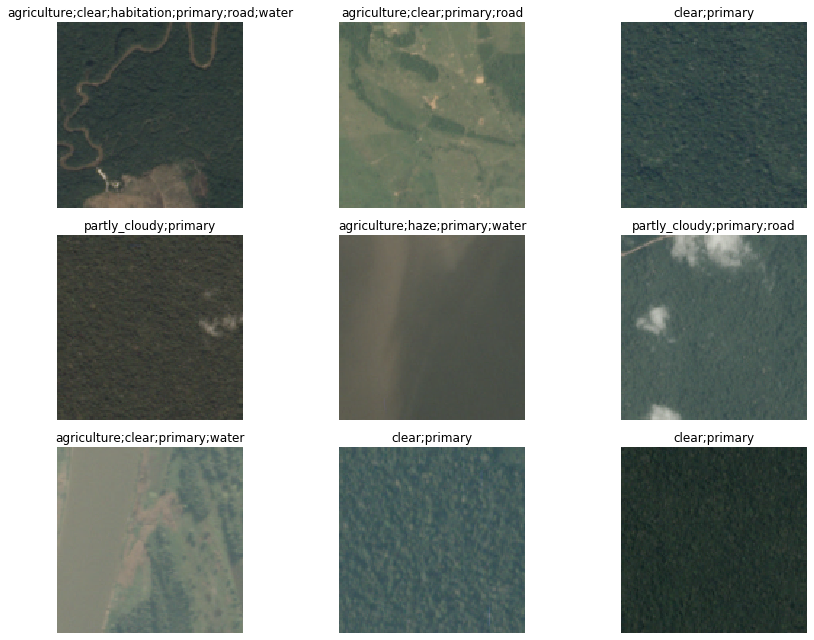

In [80]:
data.show_batch(rows=3, figsize=(12,9))

### metrics

In [81]:
arch = models.resnet50

In [86]:
fbeta??

Signature:
fbeta(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    thresh: float = 0.2,
    beta: float = 2,
    eps: float = 1e-09,
    sigmoid: bool = True,
) -> <function NewType.<locals>.new_type at 0x7f9054348290>
Source:   
def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [90]:
accuracy_thresh??

Signature:
accuracy_thresh(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    thresh: float = 0.5,
    sigmoid: bool = True,
) -> <function NewType.<locals>.new_type at 0x7f9054348290>
Source:   
def accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Computes accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return ((y_pred>thresh).byte()==y_true.byte()).float().mean()
File:      /opt/anaconda3/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


The satellite recoginition is looking for a lots of the labels

In [89]:
data.c

17

To pass the values in the function it is as follows using partial

it takes one function and keywords and values, creates a new function

In [82]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Kaggle checks fscore -- so adding the fscore

In [83]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


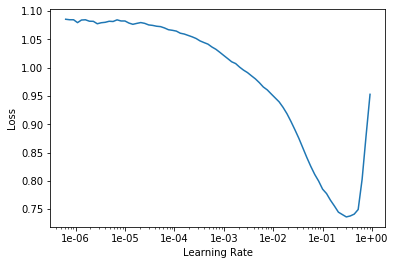

In [84]:
learn.recorder.plot()

In [88]:
lr = 0.01

In [91]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.135289,0.112920,0.946648,0.901253,01:13
1,0.115879,0.099028,0.950245,0.914730,01:12
2,0.103858,0.091569,0.955208,0.920559,01:12
3,0.094828,0.087932,0.955782,0.923475,01:12
4,0.092713,0.087287,0.955891,0.924324,01:12


In [92]:
learn.save('stage-1-rn50')

In [93]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


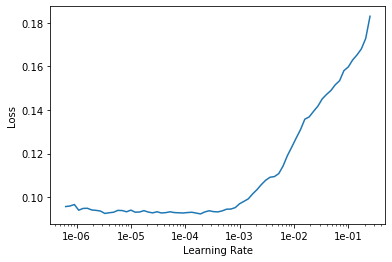

In [94]:
learn.lr_find()
learn.recorder.plot()

For first half of the slice -- look for the bottom before which there is a increase-- take 1/10 of that 

and for second half -- use actual lr used in the beginning with lr/5



In [95]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094717,0.092090,0.954968,0.918628,01:20
1,0.098870,0.089946,0.954968,0.923545,01:20
2,0.092494,0.087618,0.958805,0.925385,01:20
3,0.083507,0.083496,0.956909,0.929442,01:20
4,0.083426,0.082910,0.959053,0.929200,01:20


In [96]:
learn.save('stage-2-rn50')

To improve the fbeta further,

In the dataset created - size = 128

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
        
but the images which kaggle gave is 256

size 128 is choosen for 2 reasons:
1. smaller images are faster to experiment 


The model is now very good with 128 * 128 images

So we start with the model that is good at 128 * 128 and transfer learning.. the same model can be used

the images are 256 * 256 -- new images for the dataset

Use same learner with new images

In [97]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape


torch.Size([3, 256, 256])

We train only the last few layers, so we can freeze it again

In [98]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


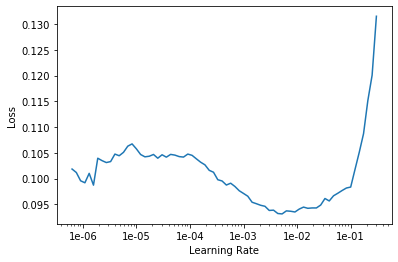

In [99]:
learn.lr_find()
learn.recorder.plot()

In [100]:
lr = 1e-2/2


In [101]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088034,0.084776,0.957061,0.926555,02:49
1,0.088977,0.084711,0.955659,0.926890,02:48
2,0.084675,0.083428,0.957599,0.927835,02:48
3,0.080765,0.081143,0.959932,0.930132,02:48
4,0.080534,0.081318,0.960310,0.929936,02:48


The accuracy has improved

In [103]:
learn.save('stage-1-256-rn50')

In [104]:
learn.unfreeze()

In [105]:
learn.fit_one_cycle(3,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087115,0.085722,0.958188,0.925827,03:41
1,0.082496,0.081320,0.958362,0.930932,03:40
2,0.080661,0.080729,0.960339,0.931443,03:40


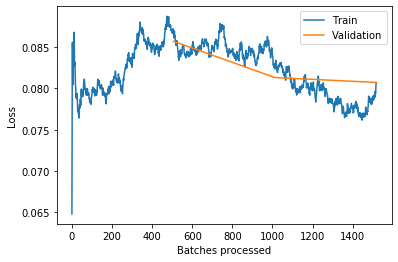

In [106]:
learn.recorder.plot_losses()

If we have misclassified instances, then take the actual misclassified data --- then use it to fit_one_cycle and learn it 